fetch data from Yahoo! Finance
YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


Price        Date       Close        High         Low        Open     Volume
Ticker                    QQQ         QQQ         QQQ         QQQ        QQQ
0      2022-01-03  393.079773  393.334216  388.382556  390.506078   40575900
1      2022-01-04  387.981262  393.666863  384.869356  393.627711   58027200
2      2022-01-05  376.062042  387.413683  375.807599  386.288281   75739800
3      2022-01-06  375.797821  379.056540  371.991125  374.232102   70814300
4      2022-01-07  371.726868  377.500568  369.945858  375.807598   72652300
..            ...         ...         ...         ...         ...        ...
817    2025-04-07  423.690002  443.140015  402.390015  408.660004  161557000
818    2025-04-08  416.059998  443.140015  409.790009  438.160004  101248100
819    2025-04-09  466.000000  467.829987  415.429993  415.570007  142876900
820    2025-04-10  446.179993  455.589996  432.630005  453.559998  108384100
821    2025-04-11  454.399994  455.790009  441.329987  444.649994   52417600

100%|██████████| 703/703 [07:29<00:00,  1.56it/s]


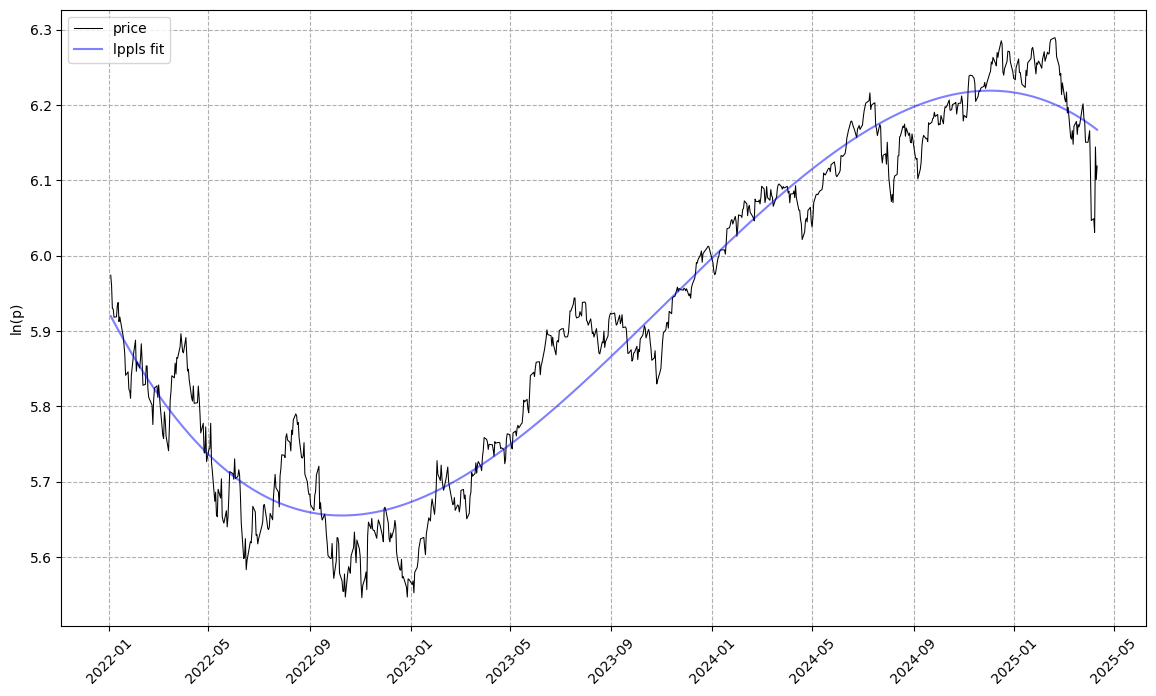

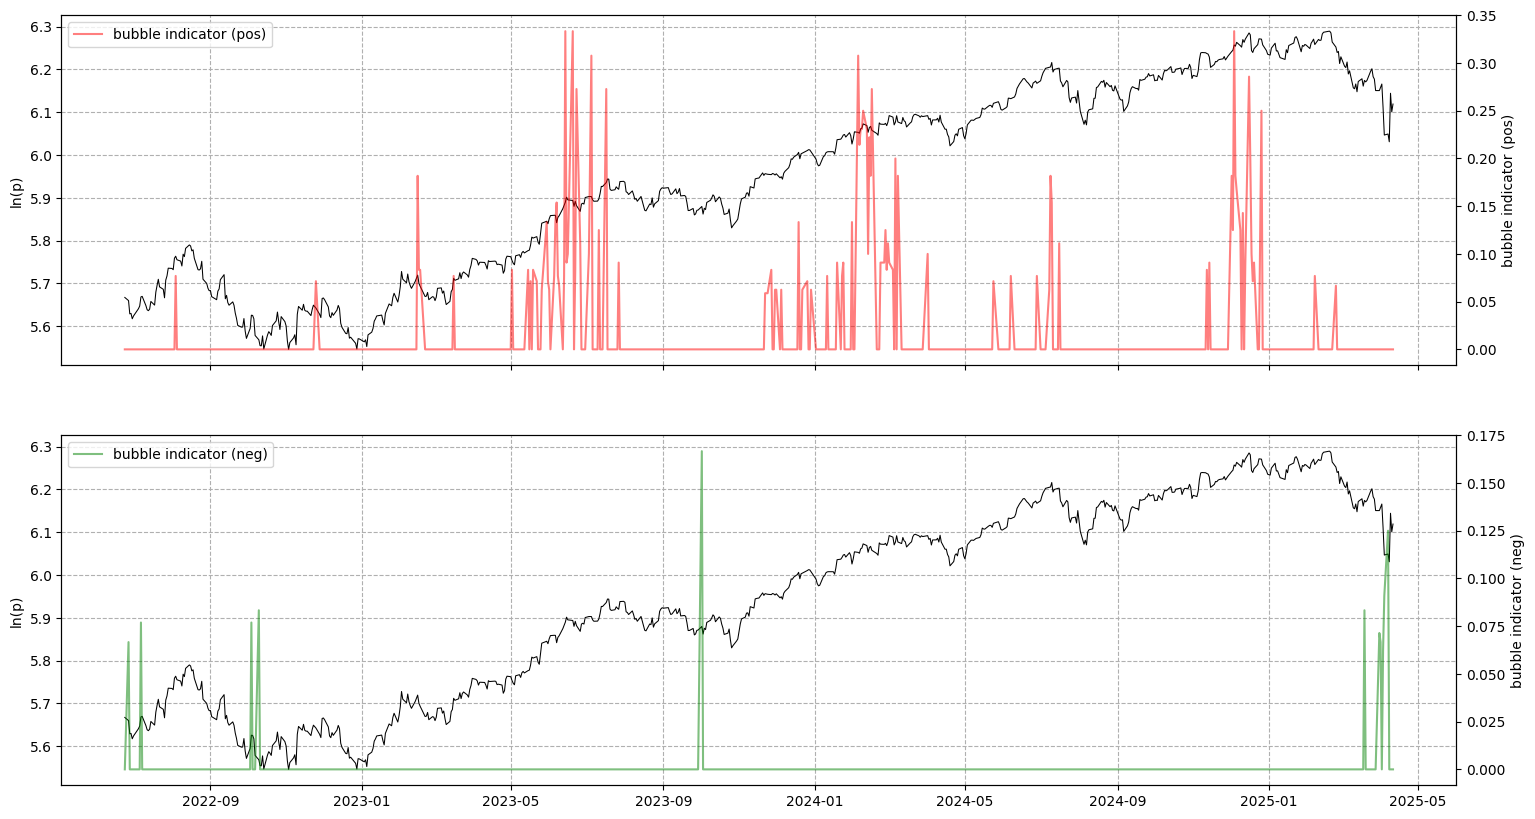

In [1]:
from lppls import lppls, data_loader
import numpy as np
import pandas as pd
from datetime import datetime as dt
import yfinance as yf
%matplotlib inline

START = '2022-01-01'
END = '2025-04-14'
LOOKBACK = 21 * 6 # 21 days in a trading month

#multiple tickers, etc
print('fetch data from Yahoo! Finance')
tickers = ['QQQ'] 
close_list = []
for ticker in tickers:
    ticker_module = yf.Ticker(ticker)
    data = yf.download(ticker, start=START, end=END)
    close = data['Close']
    # close.rename(f'{ticker} Close', inplace=True)
    close_list.append(close)
    
    data = data.reset_index()
    print(data)

    # convert time to ordinal
    time = [pd.Timestamp.toordinal(t1) for t1 in data['Date']]

    # create list of observation data
    price = np.log(data['Close'].values).flatten()

    # create observations array (expected format for LPPLS observations)
    observations = np.array([time, price])

    # set the max number for searches to perform before giving-up
    # the literature suggests 25
    MAX_SEARCHES = 25

    # instantiate a new LPPLS model with the dataset
    lppls_model = lppls.LPPLS(observations=observations)

    # fit the model to the data and get back the params
    tc, m, w, a, b, c, c1, c2, O, D = lppls_model.fit(MAX_SEARCHES)

    # visualize the fit
    lppls_model.plot_fit()

    # compute the confidence indicator
    res = lppls_model.mp_compute_nested_fits(
        workers=8,
        window_size=120, 
        smallest_window_size=30, 
        outer_increment=1, 
        inner_increment=5, 
        max_searches=25,
    )

    lppls_model.plot_confidence_indicators(res)
    # should give a plot like the following...